In [1]:
from IPython.display import Image
Image("mercari.png")


# Mercari Price Suggestion Challenge
***
### Can you automatically suggest product prices to online sellers?

**Product pricing gets even harder at scale**, considering just how many products are sold online. Clothing has strong seasonal pricing trends and is heavily influenced by brand names, while electronics have fluctuating prices based on product specs.

**Mercari**, Japan’s biggest community-powered shopping app, knows this problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari's marketplace.

In this competition, Mercari’s challenging you to **build an algorithm that automatically suggests the right product prices**. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.

### Dataset Features

- **ID**: the id of the listing
- **Name:** the title of the listing
- **Item Condition:** the condition of the items provided by the seller
- **Category Name:** category of the listing
- **Brand Name:** brand of the listing
- **Shipping:** whether or not shipping cost was provided
- **Item Description:** the full description of the item
- **Price:** the price that the item was sold for. This is the target variable that you will predict. The unit is USD.


**Source of the data challenge:** https://www.kaggle.com/c/mercari-price-suggestion-challenge

### Define the Problem


**A. Define the objective in business terms:** The objective is to come up with the right pricing algorithm that can we can use as a pricing recommendation to the users.

**B. How will your solution be used?:** Allowing the users to see a suggest price before purchasing or selling will hopefully allow more transaction within Mercari's business.

** C. How should you frame this problem?:** This problem can be solved using a supervised learning approach, and possible some unsupervised learning methods as well for clustering analysis.

** D. How should performance be measured?:** Since its a regression problem, the evaluation metric that should be used is RMSE (Root Mean Squared Error). But in this case for the competition, we'll be using the RMSLE; which puts less penalty on large errors and focuses more on the smaller errors (since our main distribution in price is centered at around $10)

**E. Are there any other data sets that you could use?:**  To get a more accurate understanding and prediction for this problem, a potential dataset that we can gather would be more about the user. Features such as user location, user gender, and seasonality.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv('train.tsv', sep='\t')

In [5]:
train_data.shape

(1482535, 8)

In [8]:
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [9]:
test_data = pd.read_csv('test.tsv', sep='\t')

In [10]:
test_data.shape

(693359, 7)

In [11]:
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [13]:
print('The training data has', train_data.shape[0],'rows and', train_data.shape[1], 'columns')
print('The test data has', test_data.shape[0],'rows and', test_data.shape[1], 'columns')

The training data has 1482535 rows and 8 columns
The test data has 693359 rows and 7 columns


In [14]:
train_data.astype('object').describe().T

,count,unique,top,freq
train_id,1482535,1482535,1482534,1
name,1482535,1225273,Bundle,2232
item_condition_id,1482535,5,1,640549
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
brand_name,849853,4809,PINK,54088
price,1.48254e+06,828,10,99416
shipping,1482535,2,0,819435
item_description,1482531,1281426,No description yet,82489


#### Initial Observations 
1. The most common title for a listing is **Bundle**.
2. The most common brand name is **PINK**.
3. Most common price points is **10 dollars**.
4. About 82k listings do not have descriptions.
5. The most common item category is **Women apparel**.
6. About 82k listings do not have shipping cost provided.

In [15]:
# Let's look at the missing values
train_data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [16]:
# filling missing values 
train_data['category_name'].fillna(value = 'Other', inplace = True)
train_data['brand_name'].fillna(value = 'Unknown', inplace = True)
train_data['item_description'].fillna(value = 'No Description', inplace = True)

In [17]:
train_data.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

### Exploratory Data Analysis

In [18]:
# let's look at Price distribution 
pd.options.display.float_format = "{:.3f}".format
train_data.price.describe()

count   1482535.000
mean         26.738
std          38.586
min           0.000
25%          10.000
50%          17.000
75%          29.000
max        2009.000
Name: price, dtype: float64

# Price Distribution
**Summary:**
    
1. Average Price of the items is **$26**

2. Median price is **$17**

3. Maximum amount is **$2000**

4. Most of the items are sold at **$10**


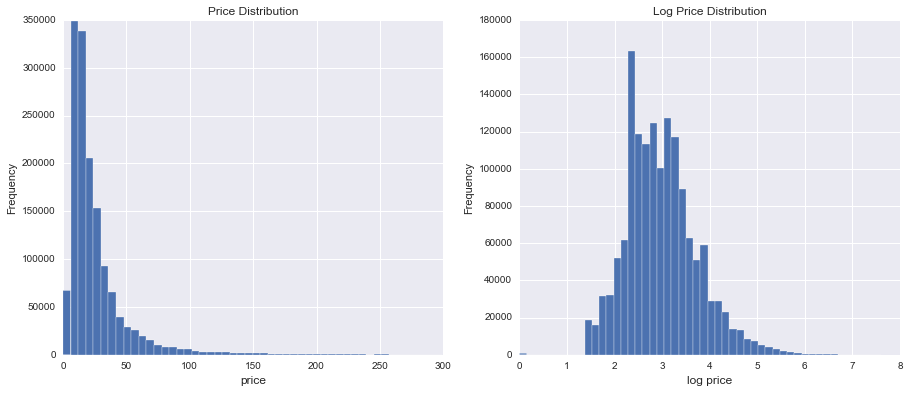

In [19]:
#let's plot the distribution for Price.
#sns.distplot(price_data['price'], bins = 50)
plt.subplot(1,2,1)
price_data = train_data.loc[train_data['price'] < 300]
price_data['price'].plot.hist(bins = 50, figsize = (15,6), edgecolor = 'white')
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)


plt.subplot(1,2,2)
price_log_data = np.log(train_data['price'] + 1)
price_log_data.plot.hist(bins = 50, figsize = (15,6),edgecolor = 'white')
plt.xlabel('log price', fontsize = 12)
plt.title('Log Price Distribution')


plt.show()

** Why we are taking log(price) ? **
* If we look at the price distribution, we see that most of the items have been sold for close to 10 dollars. The price distribution is heavily skewed on left side for lower values. Therefore we can take can transform it using log transformation.

* This is a regression problem, and the error can be measured using RMSE(Root Mean Square Error), but since price has a long right tail distribution, we should use RMSLE(Root Mean Square Log Error). We are doing this so that the errors for lower priced items are penalized more than higher priced items. 

* So, we do the log transformation of the price(our target variable). The evaluation metric is RMSLE. We then convert the log of price to actual price using exponential transformation.



**Example:**

**Step 1 Log Transformation:** np.log(train['price']+1)

**Step 2 Predict with Log Transformation:** test_pred = model.predict(X_test)

**Step 3 Convert back to original value by Exponential Transformation** Y_test = np.expm1(test_pred)


### Remove listings with zero dollars 

* Many listings have zero prices. This is data quality issue and its better to remove these listings from the data for training.
* There are 874 listings with zero prices.

In [20]:
train_data[train_data.price == 0].shape

(874, 8)

In [21]:
train_data = train_data[train_data.price !=0]

In [22]:
train_data.shape

(1481661, 8)

### Shipping distribution

In [23]:
# For more than 50% of the listings shipping cost is not included. 
train_data.shipping.value_counts()*100/len(train_data)

0   55.267
1   44.733
Name: shipping, dtype: float64

In [24]:
# let's look to see how the prices distribution for shipping 

buyer_shipping_fee = train_data.loc[train_data['shipping'] == 0, 'price']
seller_shipping_fee = train_data.loc[train_data['shipping'] == 1, 'price']

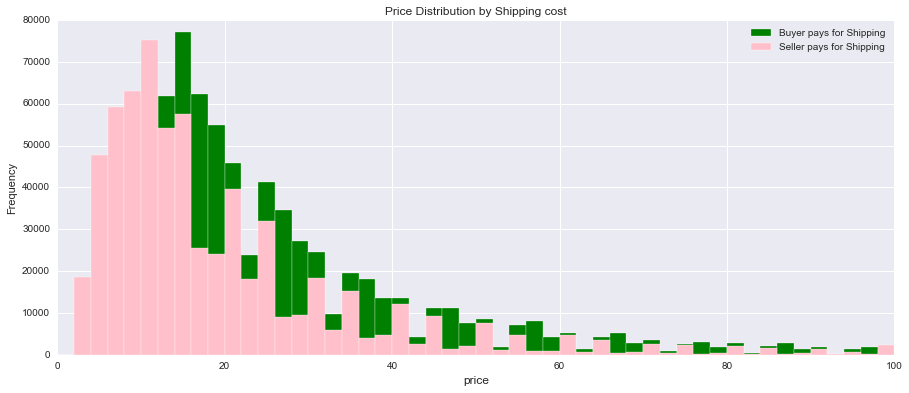

In [25]:
buyer_shipping_fee.plot.hist(bins = 50, figsize = (15,6), edgecolor = 'white', range =[0,100], 
                             color ='green', label = 'Buyer pays for Shipping')

seller_shipping_fee.plot.hist(bins = 50, figsize = (15,6), edgecolor = 'white', range =[0,100], 
                              color ='pink',label = 'Seller pays for Shipping')

plt.xlabel('price', fontsize=12)
plt.ylabel('Frequency')
plt.title('Price Distribution by Shipping cost', fontsize=12)

plt.legend()
plt.show()



* We can see from the above graph that, prices tends to be higher when shipping cost is not provided and buyer pays for the shipping.

In [26]:
print('Average Price when buyer pays for shipping: ',np.round(np.mean(buyer_shipping_fee),2))
print('Average Price when buyer pays for shipping',np.round(np.mean(seller_shipping_fee),2))

Average Price when buyer pays for shipping:  30.13
Average Price when buyer pays for shipping 22.58


### Top Selling Categories 

In [27]:
top_categories = train_data.category_name.value_counts()[0:10]
top_categories

Women/Athletic Apparel/Pants, Tights, Leggings                 60152
Women/Tops & Blouses/T-Shirts                                  46349
Beauty/Makeup/Face                                             34320
Beauty/Makeup/Lips                                             29901
Electronics/Video Games & Consoles/Games                       26547
Beauty/Makeup/Eyes                                             25200
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24668
Women/Underwear/Bras                                           21254
Women/Tops & Blouses/Tank, Cami                                20270
Women/Tops & Blouses/Blouse                                    20269
Name: category_name, dtype: int64

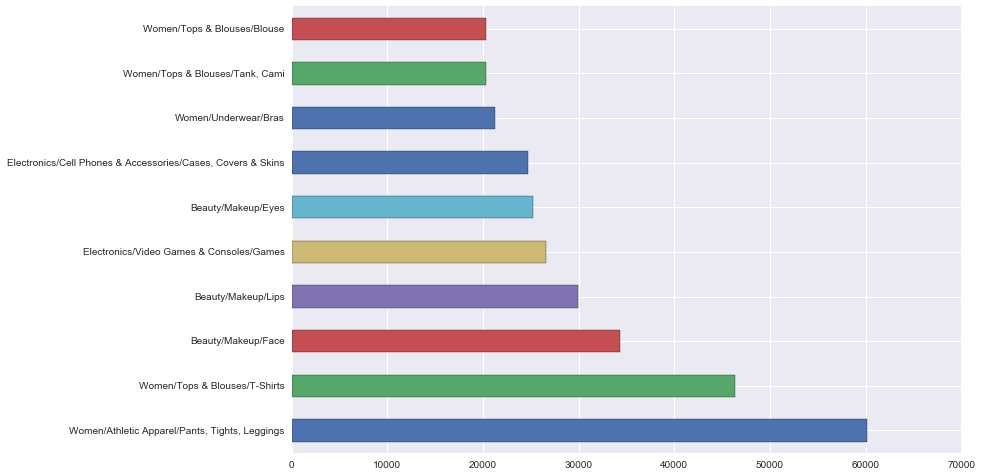

In [28]:
plt.figure(figsize=(12, 8))
top_categories.plot(kind = 'barh')

1. Women apparel is sold the most.
2. It looks like the category feature has a hirerachy like **main category/category/subcategory**, so should split them into main category and sub categories to create new features. This is feature engineering.

In [29]:
category_name = train_data['category_name']

In [30]:
def create_categories(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

In [31]:
train_data['category_main'], train_data['category_sub1'], train_data['category_sub2'] = zip(*train_data['category_name'].apply(create_categories))

In [32]:
categories_hierarchy = train_data[['category_main', 'category_sub1','category_sub2']]
categories_hierarchy.head()

,category_main,category_sub1,category_sub2
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces


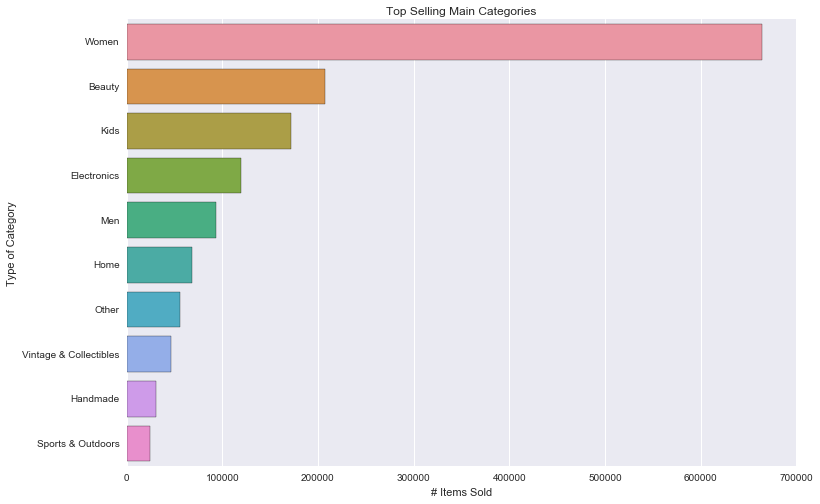

In [33]:
plt.figure(figsize=(12, 8))
sns.countplot(y = train_data['category_main'], order = train_data['category_main'].value_counts().index,
             orient = 'v')
plt.title('Top Selling Main Categories')
plt.xlabel('# Items Sold')
plt.ylabel('Type of Category')
plt.show()

* Women categories sells the most, followed by beauty and kids.

### How does Brand affects Price ? 
* let's do some analysis on the feature 'brand' and see which are most selling brands and how prices varies with the brand names. 

In [34]:
train_data['brand_name'].value_counts()[1:15].index

Index(['PINK', 'Nike', 'Victoria's Secret', 'LuLaRoe', 'Apple', 'FOREVER 21',
       'Nintendo', 'Lululemon', 'Michael Kors', 'American Eagle', 'Rae Dunn',
       'Sephora', 'Coach', 'Disney'],
      dtype='object')

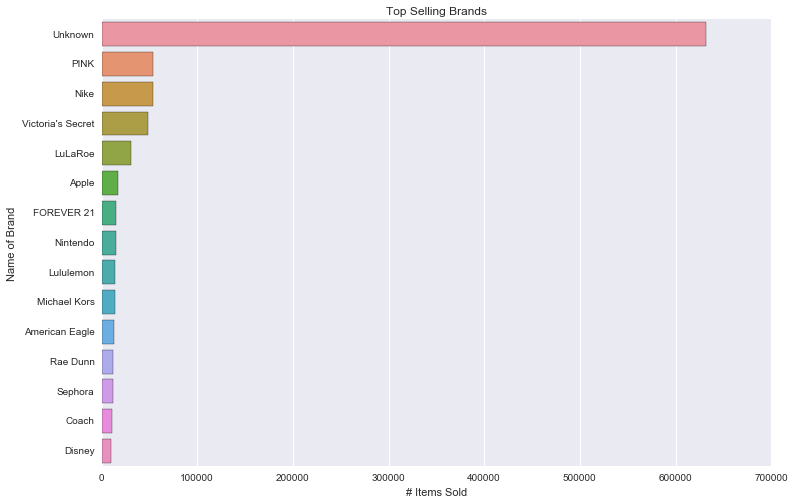

In [35]:
plt.figure(figsize=(12, 8))
sns.countplot(y = train_data['brand_name'], order = train_data['brand_name'].value_counts()[0:15].index,
             orient = 'v')
plt.title('Top Selling Brands')
plt.xlabel('# Items Sold')
plt.ylabel('Name of Brand')
plt.show()

There are a lot of items without brand names, that we have given 'unknown'. Let's remove the unknown, and see how the distribution looks like. 

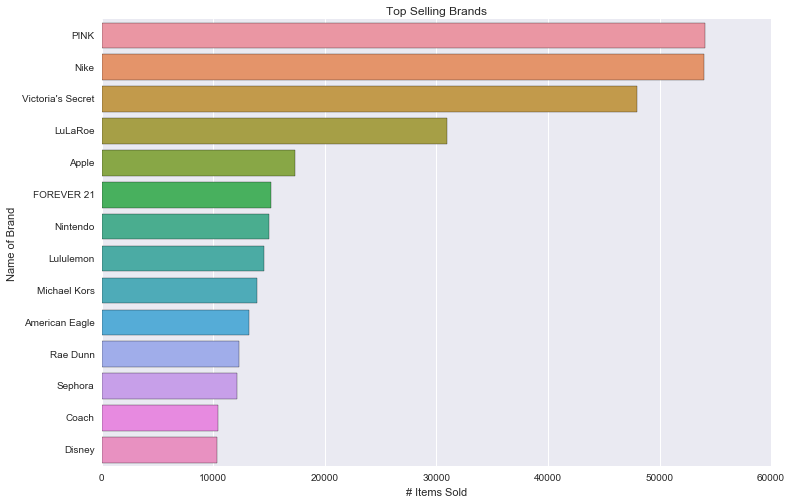

In [36]:
plt.figure(figsize=(12, 8))
sns.countplot(y = train_data['brand_name'], order = train_data['brand_name'].value_counts()[1:15].index,
             orient = 'v')
plt.title('Top Selling Brands')
plt.xlabel('# Items Sold')
plt.ylabel('Name of Brand')
plt.show()

* Pink, Nike and Victoria Secret are the most selling brands. 

### Top most expensive brands 

In [37]:
top_expensive_brands = train_data.sort_values(by=['price'],ascending=False)[0:100].reset_index()[['brand_name', 'price']]

In [38]:
most_expesive_selling_brands = top_expensive_brands.drop_duplicates(subset ="brand_name")

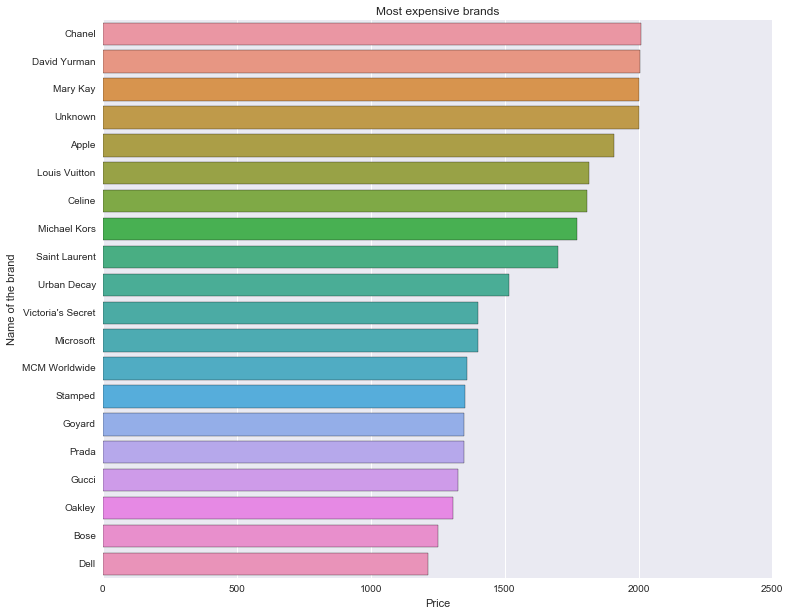

In [39]:
plt.figure(figsize=(12, 10))
sns.barplot( y='brand_name', x = 'price', data = most_expesive_selling_brands)
plt.title('Most expensive brands')
plt.ylabel('Name of the brand')
plt.xlabel('Price')
plt.show()

* Most expensive brands are Chanel, David Yurman, Mary Kay, Apple and Louis Vitton.
* We have explored all of the categorical variables, now its time to use natural language processing technique to explore text features.
* It would be good to see if the description of any particular item affects the price point of the item.

### Effect of item description length to the selling price.

In [40]:
train_data.item_description = train_data.item_description.astype(str)
train_description = train_data[['item_description','price']]

In [41]:
train_description['char count'] = train_description.item_description.apply(lambda x : len(str(x)))
train_description.head()

,item_description,price,char count
0,No description yet,10.000,18
1,This keyboard is in great condition and works ...,52.000,188
2,Adorable top with a hint of lace and a key hol...,10.000,124
3,New with tags. Leather horses. Retail for [rm]...,35.000,173
4,Complete with certificate of authenticity,44.000,41


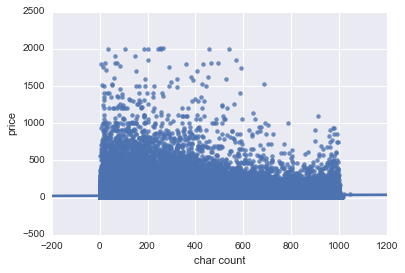

In [42]:
sns.regplot(x="char count", y="price", data= train_description[['price', 'char count']])

In [43]:
df_desc = train_description[['price', 'char count']]

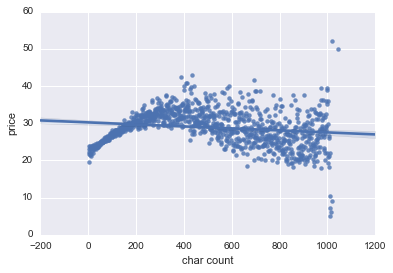

In [44]:
sns.regplot(x="char count", y="price", data= df_desc.groupby('char count')['price'].mean().reset_index())
plt.show()

* By looking at above scatter plot, it seems there is an increase in price point when the item description length goes from 0 to 400 characters. But after that it does not matter much. 


#### Normializing Text
* Removing Punctuations
* Making lower case
* Removing stop words(most common words in english language)
* Stemming the words

In [45]:
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
stop_words = stopwords.words('english')

In [46]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

In [47]:
def normalize(description):
    words = word_tokenize(description)
    words = [word.lower() for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

In [48]:
train_data['item_description'] = train_data['item_description'].apply(porter.stem)

In [49]:
train_data['item_description'] = train_data['item_description'].apply(normalize)

In [50]:
train_data['name'] = train_data['name'].apply(normalize)

In [51]:
# let's see how item description looks like after normalization and stemming
train_data['item_description'][100:105]

100    what goes better summer tacos tequila chill fr...
101                  any questions please ask price firm
102                           size medium perfect condit
103    size kids brand new paid rm firm on the price ...
104    everything perfect condition tags heaven famil...
Name: item_description, dtype: object

In [52]:
train_data['name'][5:10]

5              bundled items requested ruie
6        acacia pacific tides santorini top
7               girls cheer tumbling bundle
8                     girls nike pro shorts
9    porcelain clown doll checker pants vtg
Name: name, dtype: object

# CountVectorizer

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [54]:
# Initialize CountVectorizer
cvectorizer = CountVectorizer(max_features=20000,
                              stop_words='english', 
                              lowercase=True)

In [55]:
cvz = cvectorizer.fit_transform(train_data['item_description'])

# LDA Topic Modelling

In [56]:
from sklearn.decomposition import LatentDirichletAllocation

In [57]:
# Initialize LDA Model with 10 Topics
lda_model = LatentDirichletAllocation(n_topics=10,
                                      random_state=42)

# Fit to CountVectorizer Transformation
X_topics = lda_model.fit_transform(cvz)

/Users/rathorp/.local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [58]:
# Get the topic words
topic_word = lda_model.components_
# Get the vocabulary from the text features
vocab = cvectorizer.get_feature_names()


# Define variables
n_top_words = 10
topic_summaries = []


# Display the Topic Models
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

Topic 0: pink | blue | size | bag | black | secret | victoria | style | small | leather
Topic 1: size | new | brand | worn | tags | like | black | small | medium | fit
Topic 2: gift | baby | wore | care | oil | includes | love | jewelry | christmas | pack
Topic 3: light | use | color | inside | black | inches | gray | high | quality | great
Topic 4: white | set | oz | gold | pink | silver | red | look | print | pictures
Topic 5: rm | shipping | free | price | new | bundle | ship | firm | items | brand
Topic 6: new | brand | used | skin | color | makeup | bra | brush | lip | hair
Topic 7: box | comes | used | lot | original | picture | vintage | little | got | hand
Topic 8: iphone | case | new | phone | plus | works | twice | comes | box | used
Topic 9: condition | good | size | great | description | used | free | worn | smoke | times


In [59]:
train_data.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_main,category_sub1,category_sub2
0,0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,Unknown,10.000,1,no description yet,Men,Tops,T-shirts
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.000,0,this keyboard great condition works like came ...,Electronics,Computers & Tablets,Components & Parts


* Changing the data types for ‘item condition’, ‘brand name’, ‘category main’ to categorical variables.

In [60]:
train_data["category_main"] = train_data["category_main"].astype("category")

In [61]:
train_data["item_condition_id"] = train_data["item_condition_id"].astype("category")

In [62]:
train_data["brand_name"] = train_data["brand_name"].astype("category")

In [63]:
train_data = train_data.reset_index()

In [64]:
y_train = np.log1p(train_data['price'])

* Creating numerical vectors using **CountVectorizer** and **TFIDFVectorizer** for ‘name’ and ‘item description’, ‘category main’. 


* CountVectorizer counts the words and provides the frequencies. With the TFIDFVectorizer the value increases proportionally to count, but is offset by the frequency of the word in the corpus. - This is the IDF (inverse document frequency part). This helps to adjust for the fact that some words appear more frequently.


In [65]:
count = CountVectorizer(min_df=10) # min_df is used for removing terms that appear too infrequently.
X_name = count.fit_transform(train_data["name"])

In [66]:
count_category = CountVectorizer()
X_category = count_category.fit_transform(train_data["category_main"])

In [67]:
# max_features limit the amount of features (vocabulary) that the vectorizer will learn
# n_gram range of 1 to 3 creates vectors of one word, two words together and three words together. 
# n_grams are helful in understanding the context in the text data.
count_descp = TfidfVectorizer(max_features = 50000, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_descp = count_descp.fit_transform(train_data["item_description"])

In [68]:
from sklearn.preprocessing import LabelBinarizer
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(train_data["brand_name"])


In [69]:
import scipy
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(train_data[[
    "item_condition_id", "shipping"]], sparse = True).values)

In [70]:
X_train = scipy.sparse.hstack((X_dummies, 
                         X_descp,
                         X_brand,
                         X_category,
                         X_name)).tocsr()

In [71]:
def get_rmsle(y, pred): return np.sqrt(mean_squared_error(y, pred))

In [78]:
from sklearn.linear_model import LinearRegression

In [72]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

/Users/rathorp/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [81]:
# Create Linear Regression with 5-Fold CV

kf = KFold(X_train.shape[0],n_folds=5, shuffle=True, random_state=42)
for train_ids, valid_ids in kf:
    # Define Linear Regression Model
    model_linear = LinearRegression(fit_intercept = True, normalize = True)
    
    # Fit Ridge Regression Model
    model_linear.fit(X_train[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_linear.predict(X_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_linear.predict(X_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    
    print('Linear Regression Training RMSLE:', rmsle_train)
    print('Linear Regression Validation RMSLE', rmsle_valid)


Linear Regression Training RMSLE: 0.458452346556
Linear Regression Validation RMSLE 0.488405025765
Linear Regression Training RMSLE: 0.458636207633
Linear Regression Validation RMSLE 0.487230225134
Linear Regression Training RMSLE: 0.458547477402
Linear Regression Validation RMSLE 0.487153298977
Linear Regression Training RMSLE: 0.45850227322
Linear Regression Validation RMSLE 0.487596780558
Linear Regression Training RMSLE: 0.458025040819
Linear Regression Validation RMSLE 0.489425893927


In [89]:
# Create 5-Fold CV

kf = KFold(X_train.shape[0],n_folds=5, shuffle=True, random_state=42)
for train_ids, valid_ids in kf:
    # Define Ridge Regression Model
    model_ridge = Ridge(solver = "lsqr", fit_intercept=True, random_state=42)
    
    # Fit Ridge Regression Model
    model_ridge.fit(X_train[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(X_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(X_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    
    print('Ridge Training RMSLE:', rmsle_train)
    print('Ridge Validation RMSLE', rmsle_valid)


Ridge Training RMSLE: 0.460696098021
Ridge Validation RMSLE 0.483436825182
Ridge Training RMSLE: 0.460816943152
Ridge Validation RMSLE 0.482821694965
Ridge Training RMSLE: 0.460726824328
Ridge Validation RMSLE 0.483195138055
Ridge Training RMSLE: 0.460712610148
Ridge Validation RMSLE 0.483003514537
Ridge Training RMSLE: 0.460223776012
Ridge Validation RMSLE 0.485191056843


In [87]:
model_ridge.get_params

<bound method BaseEstimator.get_params of Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='lsqr', tol=0.001)>

In [74]:
from sklearn.linear_model import Lasso

In [75]:
kf = KFold(X_train.shape[0],n_folds=5, shuffle=True, random_state=42)
for train_ids, valid_ids in kf:
    # Define Lasso Regression Model
    
    model_LASSO = Lasso(fit_intercept=True, random_state=42)
    
    # Fit Lasso Regression Model
    model_LASSO.fit(X_train[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_LASSO.predict(X_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_LASSO.predict(X_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    
    print('Lasso Training RMSLE:', rmsle_train)
    print('Lasso Validation RMSLE', rmsle_valid)

Lasso Training RMSLE: 0.746041734891
Lasso Validation RMSLE 0.74546869127
Lasso Training RMSLE: 0.746126926423
Lasso Validation RMSLE 0.745127439068
Lasso Training RMSLE: 0.746014784538
Lasso Validation RMSLE 0.745576503564
Lasso Training RMSLE: 0.746222194481
Lasso Validation RMSLE 0.744745733984
Lasso Training RMSLE: 0.745229571533
Lasso Validation RMSLE 0.748710895468


In [76]:
from xgboost import XGBRegressor

In [77]:
kf = KFold(X_train.shape[0],n_folds=5, shuffle=True, random_state=42)
for train_ids, valid_ids in kf:
    # Define light gbm Model
    
    model_xgb = XGBRegressor()
    
    # Fit light gbm Model
    model_xgb.fit(X_train[train_ids], y_train[train_ids])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_xgb.predict(X_train[train_ids])
    rmsle_train = get_rmsle(y_pred_train, y_train[train_ids])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_xgb.predict(X_train[valid_ids])
    rmsle_valid = get_rmsle(y_pred_valid, y_train[valid_ids])
    
    
    print('XGBoost Training RMSLE:', rmsle_train)
    print('XGBoost Validation RMSLE', rmsle_valid)

XGBoost Training RMSLE: 0.626698965516
XGBoost Validation RMSLE 0.626482126363
XGBoost Training RMSLE: 0.626808921915
XGBoost Validation RMSLE 0.625717467351
XGBoost Training RMSLE: 0.626877792367
XGBoost Validation RMSLE 0.627654443712
XGBoost Training RMSLE: 0.626454974381
XGBoost Validation RMSLE 0.624583021578
XGBoost Training RMSLE: 0.626291329072
XGBoost Validation RMSLE 0.630218006305


* Out of all the three above models Ridge Regression is a better for and is performing relatively better. I will keep that as my final model.

### ELI5: which features are important for price prediction

Or, explain like I'm 5, how does a linear ridge predict prices?

ElL5 is a library that can help us with that, let's see it in action. It has support for many models, including XGBoost and LightGBM, but we'll be using it to analyze our final Ridge mode. 

In [93]:
import eli5
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [94]:
train = pd.read_csv('train.tsv', sep='\t')

In [95]:
y_train = np.log1p(train['price'])
train['category_name'] = train['category_name'].fillna('Other').astype(str)
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['item_description'] = train['item_description'].fillna('None')

In [96]:
default_preprocessor = CountVectorizer().build_preprocessor()
def build_preprocessor(field):
    field_idx = list(train.columns).index(field)
    return lambda x: default_preprocessor(x[field_idx])
    
vectorizer = FeatureUnion([
    ('name', CountVectorizer(
        ngram_range=(1, 2),
        max_features=50000,
        preprocessor=build_preprocessor('name'))),
    ('category_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('category_name'))),
    ('brand_name', CountVectorizer(
        token_pattern='.+',
        preprocessor=build_preprocessor('brand_name'))),
    ('shipping', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('shipping'))),
    ('item_condition_id', CountVectorizer(
        token_pattern='\d+',
        preprocessor=build_preprocessor('item_condition_id'))),
    ('item_description', TfidfVectorizer(
        ngram_range=(1, 3),
        max_features=100000,
        preprocessor=build_preprocessor('item_description'))),
])
X_train_eli = vectorizer.fit_transform(train.values)
X_train_eli

<1482535x156105 sparse matrix of type '<class 'numpy.float64'>'
	with 74565034 stored elements in Compressed Sparse Row format>

In [99]:
kf = KFold(X_train_eli.shape[0],n_folds=5, shuffle=True, random_state=42)

for train_ids, valid_ids in kf:
    model = Ridge(
        solver='auto',
        fit_intercept=True,
        alpha=0.5,
        max_iter=100,
        normalize=False,
        tol=0.05)
    model.fit(X_train_eli[train_ids], y_train[train_ids])
    y_pred_valid = model.predict(X_train_eli[valid_ids])
    rmsle = get_rmsle(y_pred_valid, y_train[valid_ids])
    print('model validation RMSLE:', rmsle)
    

model validation RMSLE: 0.45407900338
model validation RMSLE: 0.452564491816
model validation RMSLE: 0.453743390882
model validation RMSLE: 0.454670139753
model validation RMSLE: 0.451308318264
CPU times: user 2min 25s, sys: 14.2 s, total: 2min 39s
Wall time: 2min 45s


In [100]:
eli5.show_weights(model, vec=vectorizer)

Weight?,Feature
+2.972,<BIAS>
+1.814,item_description__14k
+1.740,name__dockatot
+1.725,item_description__limbs
+1.666,brand_name__david yurman
+1.581,item_description__carat
+1.567,item_description__unlocked
+1.485,name__tieks
+1.464,name__hatchimals
+1.456,name__hatchimal


In [101]:
eli5.show_prediction(model, doc=train.values[100], vec=vectorizer)